# Introduction to Data Science - Assignment 4
---

This project focuses on exploring different loss functions and applying gradient descent methods for optimization. The dataset used is the Diabetes dataset from the `scikit-learn` library, which contains medical diagnostic measurements from patients and is aimed at studying diabetes progression. The goal is to predict the quantitative measure of disease progression one year after baseline, thereby practicing regression analysis in a medical context.

**Diabetes Dataset:**

- Age (age in years)
- Sex
- Body Mass Index (BMI)
- Average Blood Pressure (BP)
- Six blood serum measurements:
    - s1: tc, total serum cholesterol
    - s2: ldl, low-density lipoproteins
    - s3: hdl, high-density lipoproteins
    - s4: tch, total cholesterol / HDL
    - s5: ltg, possibly log of serum triglycerides level
    - s6: glu, blood sugar level

# Warm Up

In [ ]:
from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


class LossFuncs:
    @staticmethod
    def MSE(y_true: np.array, y_pred:np.array):
        return np.sum((y_true - y_pred) ** 2) / y_true.shape[0]

    @staticmethod
    def RMSE(y_true: np.array, y_pred:np.array):
        return np.sqrt(LossFuncs.MSE(y_true, y_pred))

    @staticmethod
    def MAE(y_true: np.array, y_pred:np.array):
        return np.sum(np.abs(y_true - y_pred)) / y_true.shape[0]

    @staticmethod
    def R2(y_true: np.array, y_pred:np.array):
        return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_pred - np.mean(y_pred)) ** 2)

    @staticmethod
    def adjustedR2(y_true: np.array, y_pred:np.array, k):
        n = y_true.shape[0]
        return 1 - (((1 - LossFuncs.R2(y_true, y_pred)) * (n - 1)) / (n - k - 1))

class Model:
    def __init__(self, data: pd.DataFrame, model = LinearRegression()) -> None:
        self.data = data
        self.model = model

    def normalize(self, scaler):
        if(scaler == None):
            self.normalized_data = self.data
            return
        self.normalized_data = scaler.fit_transform(self.data)
        self.normalized_data = pd.DataFrame(self.normalized_data, columns=self.data.columns)


    def train_test_split(self, test_size, target, verify = True, return_data = False):
        self.X = self.normalized_data.drop(target, axis=1)
        self.y = self.normalized_data[target]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, shuffle=True)

        if(verify):
          print(f'number of instances of Train data: {self.X_train.shape[0]} which is {self.X_train.shape[0] / (self.X_train.shape[0] + self.X_test.shape[0]):.2f} percent of data')
          print(f'number of instances of Test data: {self.X_test.shape[0]} which is {self.X_test.shape[0] / (self.X_train.shape[0] + self.X_test.shape[0]):.2f} percent of data')

        if(return_data):
          return self.X_train, self.X_test, self.y_train, self.y_test


    def fit(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self, to_predict):
        return self.model.predict(to_predict)

    def predict_train_test(self):
        self.y_pred_train = self.model.predict(self.X_train)
        self.y_pred_test = self.model.predict(self.X_test)

    def quick_fit(self, scaler, test_size, target):
        self.normalize(scaler)
        self.train_test_split(test_size, target, verify=False, return_data=False)
        self.fit()
        self.predict_train_test()
        self.evaluate()

    def evaluate(self):
        from tabulate import tabulate
        errors = ['Data Type/Optimizer', 'MSE', 'MAE', 'RMSE', 'R2', 'Adjusted R2']
        train = [
            'train',
            LossFuncs.MSE(self.y_pred_train, self.y_train),
            LossFuncs.MAE(self.y_pred_train, self.y_train),
            LossFuncs.RMSE(self.y_pred_train, self.y_train),
            LossFuncs.R2(self.y_pred_train, self.y_train),
            LossFuncs.adjustedR2(self.y_pred_train, self.y_train, k = self.X.shape[1])
        ]
        test = [
            'test',
            LossFuncs.MSE(self.y_pred_test, self.y_test),
            LossFuncs.MAE(self.y_pred_test, self.y_test),
            LossFuncs.RMSE(self.y_pred_test, self.y_test),
            LossFuncs.R2(self.y_pred_test, self.y_test),
            LossFuncs.adjustedR2(self.y_pred_test, self.y_test, k = self.X.shape[1])
        ]
        table = [errors, train, test]
        print(tabulate(table, headers='firstrow', tablefmt='grid'))

**1. Load the diabetes dataset provided by scikit-learn (scaled=False)**

In [ ]:
diabetes = datasets.load_diabetes(scaled=False)

features = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
target = pd.Series(diabetes.target, name='target')
data = pd.concat([features, target], axis=1)
data.to_csv('diabetes_dataset.csv', index=False)

**2. Display the first ten rows of the dataset to understand its structure.**

In [ ]:
data.head(10)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.00,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
5,23.0,1.0,22.6,89.0,139.0,64.8,61.0,2.00,4.1897,68.0,97.0
6,36.0,2.0,22.0,90.0,160.0,99.6,50.0,3.00,3.9512,82.0,138.0
7,66.0,2.0,26.2,114.0,255.0,185.0,56.0,4.55,4.2485,92.0,63.0
8,60.0,2.0,32.1,83.0,179.0,119.4,42.0,4.00,4.4773,94.0,110.0
9,29.0,1.0,30.0,85.0,180.0,93.4,43.0,4.00,5.3845,88.0,310.0


**3. Print the data types of each feature to ensure they are numeric.**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


**4.  Check for any missing values in the dataset and handle them appropriately (if missing values exist).**

In [ ]:
data.isnull().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

**5. Normalize the features to ensure all are on a similar scale.**

In [ ]:
model = Model(data, model=LinearRegression())
normalized_data = model.normalize(StandardScaler())
model.normalized_data


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.800500,1.065488,1.297088,0.459841,-0.929746,-0.732065,-0.912451,-0.054499,0.418531,-0.370989,-0.014719
1,-0.039567,-0.938537,-1.082180,-0.553505,-0.177624,-0.402886,1.564414,-0.830301,-1.436589,-1.938479,-1.001659
2,1.793307,1.065488,0.934533,-0.119214,-0.958674,-0.718897,-0.680245,-0.054499,0.060156,-0.545154,-0.144580
3,-1.872441,-0.938537,-0.243771,-0.770650,0.256292,0.525397,-0.757647,0.721302,0.476983,-0.196823,0.699513
4,0.113172,-0.938537,-0.764944,0.459841,0.082726,0.327890,0.171178,-0.054499,-0.672502,-0.980568,-0.222496
...,...,...,...,...,...,...,...,...,...,...,...
437,0.876870,1.065488,0.413360,1.256040,-0.119769,-0.053957,-0.602843,-0.054499,0.655787,0.151508,0.335904
438,-0.115937,1.065488,-0.334410,-1.422086,1.037341,1.664355,-0.602843,0.721302,-0.380819,0.935254,-0.625064
439,0.876870,1.065488,-0.334410,0.363573,-0.785107,-0.290965,-0.525441,-0.232934,-0.985649,0.325674,-0.261454
440,-0.956004,-0.938537,0.821235,0.025550,0.343075,0.321306,-0.602843,0.558384,0.936163,-0.545154,0.881318


**6. Split the data into training and testing sets using a standard ratio (e.g., 95% training, 5% testing). Utilize sklearn's train_test_split function or an equivalent method ensuring a random split**

**7. Display the number of instances in both the training and the testing datasets to confirm the split**

In [ ]:
model.train_test_split(test_size=0.1, target='target', verify=True)

number of instances of Train data: 397 which is 0.90 percent of data
number of instances of Test data: 45 which is 0.10 percent of data


# Main Task

## Part1
Implement the following functions from scratch: Mean Squared Error (MSE), Mean
Absolute Error (MAE), Root Mean Squared Error (RMSE), R² Score (Coefficient of
Determination)


- Mean Squared Error (MSE):
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

- Mean Absolute Error (MAE):
$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

- Root Mean Squared Error (RMSE):
$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

- R² Score (Coefficient of Determination)
$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

## Part 2:
Building and Training the Linear Regression Model

In [ ]:
model.fit()
model.predict_train_test()

## Part 3:
Model Evaluation

In [ ]:
model.evaluate()

+-----------------------+----------+----------+----------+----------+---------------+
| Data Type/Optimizer   |      MSE |      MAE |     RMSE |       R2 |   Adjusted R2 |
+=======================+==========+==========+==========+==========+===============+
| train                 | 0.477458 | 0.557645 | 0.690983 | 0.526642 |      0.514379 |
+-----------------------+----------+----------+----------+----------+---------------+
| test                  | 0.533273 | 0.61482  | 0.730255 | 0.415413 |      0.243476 |
+-----------------------+----------+----------+----------+----------+---------------+


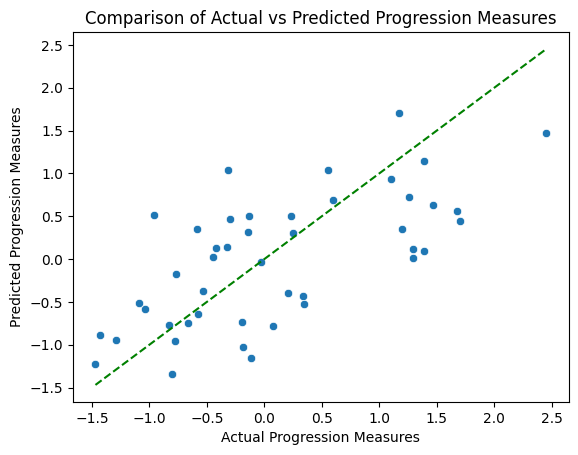

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sea

sea.scatterplot(x = model.y_test, y = model.y_pred_test)
plt.plot([model.y_test.min(), model.y_test.max()], [model.y_test.min(), model.y_test.max()], linestyle='--', color='green')
plt.xlabel('Actual Progression Measures')
plt.ylabel('Predicted Progression Measures')
plt.title('Comparison of Actual vs Predicted Progression Measures')
plt.show()

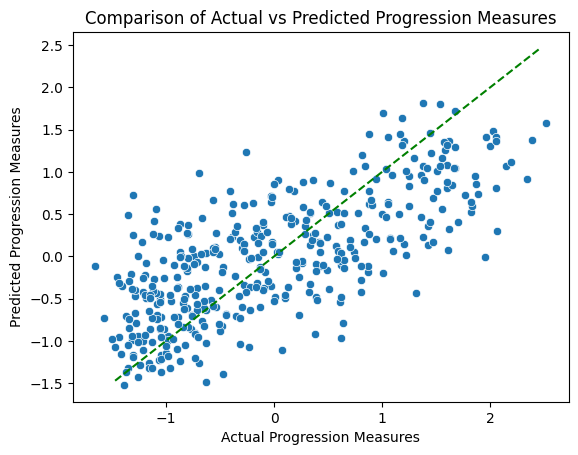

In [ ]:
sea.scatterplot(x = model.y_train, y = model.y_pred_train)
plt.plot([model.y_test.min(), model.y_test.max()], [model.y_test.min(), model.y_test.max()], linestyle='--', color='green')
plt.xlabel('Actual Progression Measures')
plt.ylabel('Predicted Progression Measures')
plt.title('Comparison of Actual vs Predicted Progression Measures')
plt.show()

## Part 4:
Use OLS from the scipy library, train the model, and finally display the statistics
obtained from this process

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(model.X)
ols = sm.OLS(model.y, X)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           3.83e-62
Time:                        16:50:59   Log-Likelihood:                -466.00
No. Observations:                 442   AIC:                             954.0
Df Residuals:                     431   BIC:                             999.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.671e-16      0.033  -4.99e-15      1.0

# Extra Tasks

## 1. Correlations

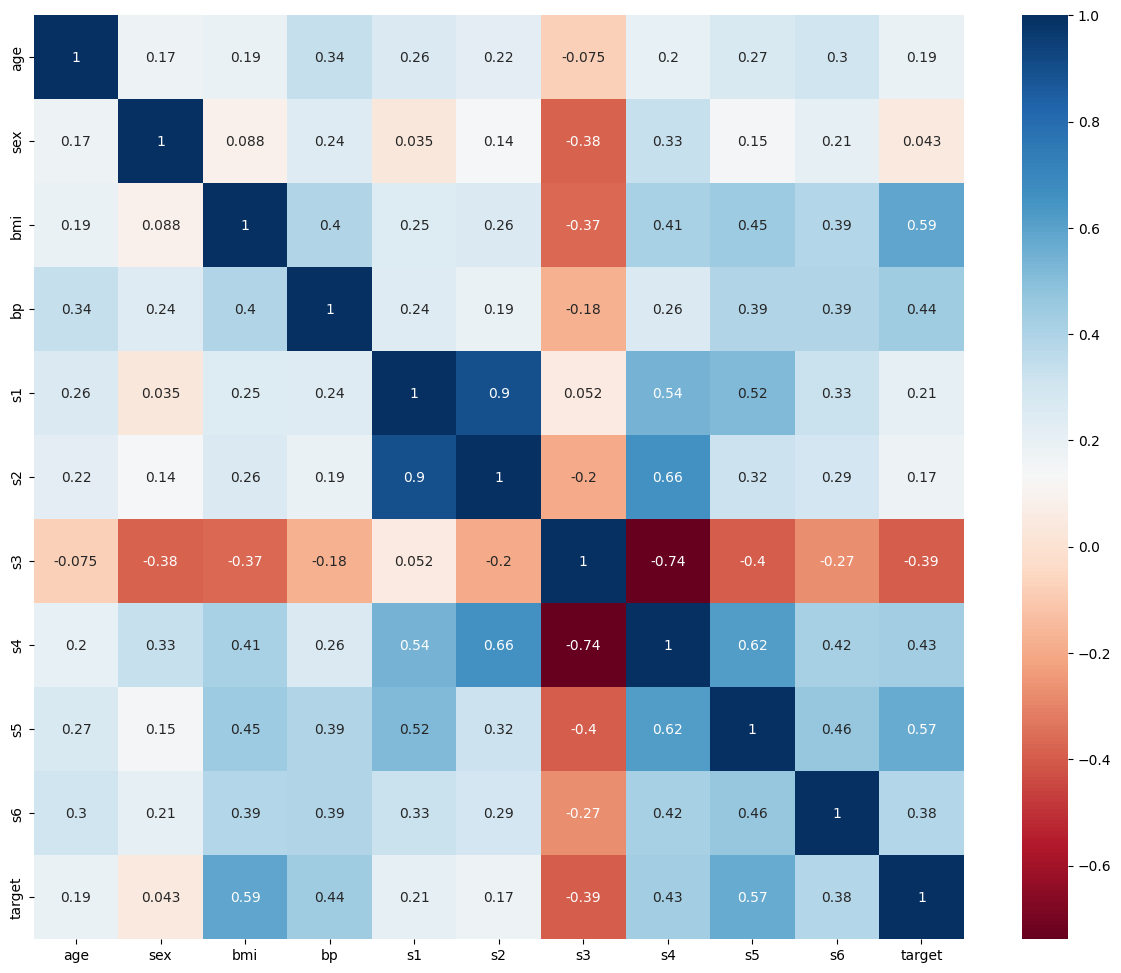

In [ ]:
plt.figure(figsize=(15, 12))
cmap = sea.diverging_palette(220, 220, as_cmap=True)
sea.heatmap(data.corr(), annot=True, cmap='RdBu')
plt.show()

## 2. Correlations with the Target and Model Coefficients

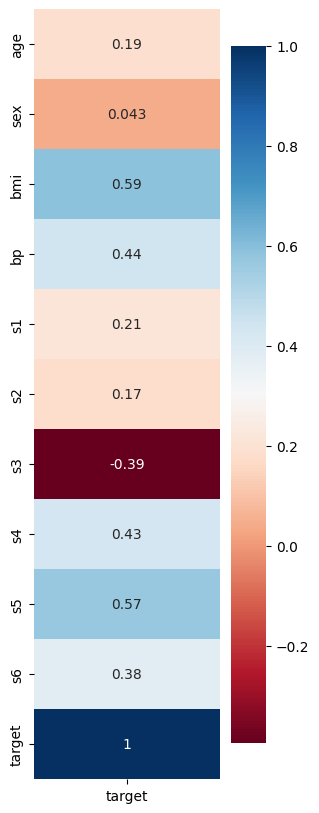

In [ ]:
plt.figure(figsize=(3, 10))
cmap = sea.diverging_palette(220, 220, as_cmap=True)
sea.heatmap(data.corr()[['target']], annot=True, cmap='RdBu')
plt.show()


In [ ]:
model = Model(data, LinearRegression())
model.quick_fit(StandardScaler(), 0.1, 'target')
pd.DataFrame(model.model.coef_.reshape(1,10), columns = model.X.columns)

+-----------------------+----------+----------+----------+----------+---------------+
| Data Type/Optimizer   |      MSE |      MAE |     RMSE |       R2 |   Adjusted R2 |
+=======================+==========+==========+==========+==========+===============+
| train                 | 0.476105 | 0.561158 | 0.690003 | 0.510291 |      0.497604 |
+-----------------------+----------+----------+----------+----------+---------------+
| test                  | 0.553633 | 0.57465  | 0.744065 | 0.546736 |      0.413423 |
+-----------------------+----------+----------+----------+----------+---------------+


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.01947,-0.137038,0.308551,0.215621,-0.409481,0.202713,0.035188,0.140028,0.416437,0.030716


## 3. Try Other Regression Models

In [ ]:
!pip install lazypredict
from lazypredict.Supervised import LazyRegressor
model = Model(data, LinearRegression())
model.normalize(StandardScaler())
X_train, X_test, y_train, y_test = model.train_test_split(test_size = 0.05, target='target', verify=False, return_data=True)
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None);
models, predictions = reg.fit(X_train, X_test, y_train, y_test);


100%|██████████| 42/42 [00:02<00:00, 15.14it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 419, number of used features: 10
[LightGBM] [Info] Start training from score -0.000370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.15,0.54,0.68,0.20
BaggingRegressor,0.15,0.54,0.68,0.05
RandomForestRegressor,0.13,0.52,0.69,0.30
SVR,0.13,0.52,0.69,0.02
MLPRegressor,0.12,0.52,0.70,0.50
GradientBoostingRegressor,0.11,0.51,0.70,0.21
KNeighborsRegressor,0.04,0.48,0.72,0.02
SGDRegressor,0.04,0.48,0.72,0.01
NuSVR,0.04,0.48,0.72,0.04


## 4. Effect of Different Scalings on Loss Functions

- `MinMax` scaling scales the features to a specific range, usually between 0 and 1. It preserves the original distribution of the data but compresses it within the specified range. It is particularly useful when we have features with different scales and we want to bring them to a similar range.

- `Standard` scaling, on the other hand, transforms the features to have zero mean and unit variance. It centers the data around zero and scales it based on the standard deviation. It assumes that the data follows a Gaussian distribution and aims to make the features have similar variances.

In [ ]:
model = Model(data, LinearRegression())
model.quick_fit(MinMaxScaler(), 0.1, 'target')

+-----------------------+-----------+----------+----------+----------+---------------+
| Data Type/Optimizer   |       MSE |      MAE |     RMSE |       R2 |   Adjusted R2 |
+=======================+===========+==========+==========+==========+===============+
| train                 | 0.0270022 | 0.133221 | 0.164323 | 0.511355 |      0.498696 |
+-----------------------+-----------+----------+----------+----------+---------------+
| test                  | 0.0352712 | 0.150502 | 0.187806 | 0.538955 |      0.403354 |
+-----------------------+-----------+----------+----------+----------+---------------+


## 5. Effect of Regularization in Linear Regression

In [ ]:
from sklearn.linear_model import Ridge

model = Model(data, Ridge(alpha = 0.5))
model.quick_fit(StandardScaler(), 0.1, 'target')

+-----------------------+----------+----------+----------+----------+---------------+
| Data Type/Optimizer   |      MSE |      MAE |     RMSE |       R2 |   Adjusted R2 |
+=======================+==========+==========+==========+==========+===============+
| train                 | 0.49125  | 0.566766 | 0.700893 | 0.509801 |      0.497101 |
+-----------------------+----------+----------+----------+----------+---------------+
| test                  | 0.411754 | 0.511749 | 0.641681 | 0.564327 |      0.436188 |
+-----------------------+----------+----------+----------+----------+---------------+


# Questions


## **1. Analyze and evaluate the values in Table (1).**


- **MAE**: This is the average absolute difference between the predicted and actual values. Lower values are better. Our model has a `MAE` of 0.568 on the training set and 0.450 on the test set. The lower `MAE` on the test set suggests that the model is not overfitting and is generalizing well to unseen data.

- **MSE**: This is the average of the squared differences between the predicted and actual values. Lower values are better. Our model has a `MSE` of 0.494 on the training set and 0.284 on the test set. The lower `MSE` on the test set, like the `MAE`, suggests good generalization.

- **RMSE**: This is the square root of the `MSE`. It has the same units as the output variable, making it more interpretable than the `MSE`. The model has a RMSE of 0.703 on the training set and 0.533 on the test set. The lower `RMSE` on the test set indicates good performance.

- **R2**: This is the proportion of variance in the dependent variable that is predictable from the independent variables. Higher values (closer to 1) are better. We got a low `R2` of 0.023 on the training set, suggesting that the model does not explain much of the variability in the data. However, the `R2` is significantly higher on the test set (0.354), which is a good sign.

- **Adjusted R2**: This is a modified version of `R2` that adjusts for the number of predictors in the model. It is **always** lower than `R2`. Our model has a negative adjusted R2 on both the training and test sets, which suggests that the model could be improved by removing some predictors.

In overall, we can see that the model seems to be performing well on the test set based on the `MAE`, `MSE`, and `RMSE`.

However, the low `R2` and negative `adjusted R2` suggest that the model is not explaining much of the variability in the data and could potentially be improved.

## **2. Review the R² and Adjusted R² values obtained in part 4. Explain what these values indicate and what the implications of high or low values might be. Also, discuss the differences between these two metrics.**

**R-squared (R²):**
  - R-squared is a statistical measure that represents the proportion of the variance in the dependent variable that is predictable from the independent variables. In this case, an R² of 0.518 indicates that approximately 51.8% of the variance in the target variable can be explained by the independent variables in the model.

**Adjusted R-squared (Adj. R²):**
  - Adjusted R-squared is a modified version of R-squared that adjusts for the number of predictors in the model. It penalizes the addition of unnecessary variables that do not improve the model significantly. In this case, an Adj. R² of 0.507 suggests that the independent variables collectively explain about 50.7% of the variance in the target variable, considering the number of predictors in the model.

**Implications:**
- **High R²/Adj. R²:** A high R² value close to 1 indicates that a large proportion of the variance in the dependent variable is explained by the independent variables. It suggests that the model fits the data well.
- **Low R²/Adj. R²:** A low R² value closer to 0 implies that the independent variables do not explain much of the variance in the dependent variable. It may indicate that the model does not fit the data well or that important variables are missing.

**Differences:**
- R-squared tends to increase as more variables are added to the model, even if those variables are not truly improving the model's predictive power. Adjusted R-squared, on the other hand, considers the number of predictors in the model and penalizes the addition of irrelevant variables, providing a more accurate assessment of the model's goodness of fit.



## **3. Review the p-values obtained in part 4 for each column of data and explain what these values indicate.Discuss what an appropriate value for p-values is and which columns currently have suitable values.**

In [ ]:
print("P-values:")
print(results.pvalues)

P-values:
const   1.00
age     0.87
sex     0.00
bmi     0.00
bp      0.00
s1      0.06
s2      0.16
s3      0.63
s4      0.27
s5      0.00
s6      0.31
dtype: float64


P-values are used in hypothesis testing to help support or reject the null hypothesis. They represent the probability that the results of the test occurred at random. If p is low (usually p < 0.05), it's unlikely that the results happened by chance, and we can reject the null hypothesis.

Obtained p-values indicate:

- **const: 1.00** - This suggests that the variable 'const' is not statistically significant in our model, as the p-value is not less than 0.05.
- **age: 0.87** - The variable 'age' is also not statistically significant, as its p-value is greater than 0.05.
- **sex: 0.00, bmi: 0.00, bp: 0.00, s5: 0.00** - These variables can be statistically significant in the dataset, as their p-values are less than 0.05.
- **s1: 0.06** - This variable is on the edge of being statistically significant. Based on the research we want to do, we can decide whether to consider it significant or not.
- **s2: 0.16, s3: 0.63, s4: 0.27, s6: 0.31** - These variables are not statistically significant as their p-values are greater than 0.05.

In general, a p-value less than 0.05 is considered statistically significant.  However, the threshold for significance can vary depending on the field of study and the specific research question. Some researchers might use a more stringent threshold (like 0.01), while others might use a more lenient one (like 0.10). It's always important to consider the context of the analysis when interpreting p-values.


## **4. Assess and analyze the importance of each feature in the dataset based on the results obtained in part 4 regarding an individual's diabetic condition.**


In OLS regression, the coefficients of each feature indicate the strength and direction of the relationship between that feature and the target variable. Here's an assessment and analysis of the importance of each feature:

1. **Age**: This coefficient is -0.0062 with a high standard error (0.037) and a high p-value (0.867), indicating that age may not be statistically significant in predicting the target variable (possibly blood sugar levels). So age may not be an important predictor in this model.

2. **Sex**: The coefficient is -0.1481 with a low p-value (p < 0.001), suggesting that sex is statistically significant in predicting the target variable. However, the coefficient is relatively small, indicating a modest effect on the target variable compared to other features.

3. **BMI (Body Mass Index)**: This coefficient is 0.3211 with a low p-value (p < 0.001), indicating that BMI is highly statistically significant in predicting the target variable. Moreover, the coefficient is relatively large, suggesting that BMI has a significant impact on the target variable.

4. **Blood Pressure (bp)**: The coefficient is 0.2004 with a low p-value (p < 0.001), indicating that blood pressure is statistically significant in predicting the target variable. However, its effect seems slightly smaller compared to BMI.

5. **s1, s2, s3, s4, s5, s6**: These are different blood serum measurements. Among these, only s5 has a high coefficient (0.4640) with a low p-value (p < 0.001), indicating that it is highly statistically significant and has a strong impact on the target variable. The other serum measurements (s1, s2, s3, s4, s6) have coefficients close to zero or relatively small with higher p-values, suggesting that they might not be as important in predicting the target variable in this model.

In overall, based on the OLS regression results:

- **Important features**: BMI, Blood Pressure (bp), s5 (one of the serum measurements), and to a lesser extent, sex.
  
- **Less important features**: Age, and the other serum measurements (s1, s2, s3, s4, s6) may not significantly contribute to predicting the target variable in this model.

# Group Members

* Matin Bazrafshan - 810100093
* Mohammad Reza Nemati - 810100226
* Parva Sharifi - 810100171
* Mohammad Farrahi - 810198451

